In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage
import random
import cv2
import heapq
import time

from frechetdist import frdist
from refine_transform import match_fragments, Translation
from find_transform import estimate_transform_params, transform_line, estimate_mean_squared_transformation_error

from utils import build_fragment, Fragment, rotate_fragment, pad_fragment
from utils import shift_fragment, blend_fragments, transform_fragment

from shape_align import align_two_fragments, pairwise_alignment
from find_transform import find_best_transform_ransac, aligned_coords2line

from shape_utils import get_colorized_edge
from shape_utils import linearize_edge
from curvature import edge_coords2curvatures
from shape_align import water
from typing import List, Dict, Tuple
from joblib import Parallel, delayed
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm
from dataclasses import dataclass
from scipy.ndimage import shift

In [2]:
data_dir = '../voronoi/example'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [3]:
frag1 = build_fragment(11, None)
frag2 = build_fragment(14, None)
frag3 = rotate_fragment(pad_fragment(frag1, 200), 60)

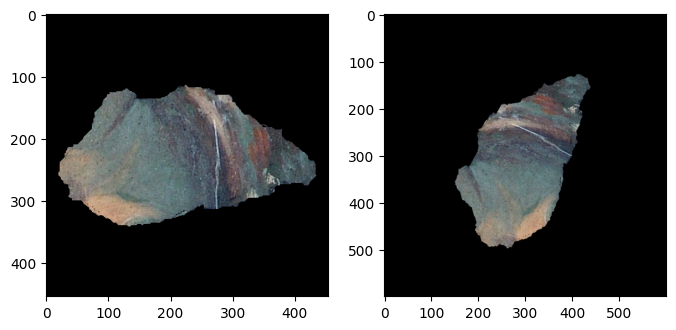

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag3.fragment)

In [5]:
def find_best_fragment_transform(palette, frag1, frag2):
    frags = [frag1, frag2]
    descriptors, alignment = pairwise_alignment(palette, frags)
    line1 = aligned_coords2line(alignment[(0, 1)], descriptors[0].edge_coords, left=True)
    line2 = aligned_coords2line(alignment[(0, 1)], descriptors[1].edge_coords[::-1], left=False)
    line1 -= frag1.fragment.shape[0] // 2
    line2 -= frag2.fragment.shape[0] // 2
    best_transform = find_best_transform_ransac(line1, line2)
    return best_transform, line1, line2

In [6]:
best_transform_params, subcurve1, subcurve2 = find_best_fragment_transform(
    palette, 
    frag3,
    frag2
)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|██████████████████████████████████████████████████████████████████████████████| 1902/1902 [00:07<00:00, 253.66it/s]


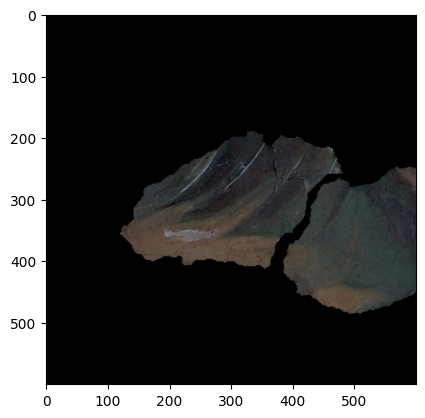

In [7]:
blended = blend_fragments(
    pad_fragment(frag2, 200),
    shift_fragment(
        rotate_fragment(pad_fragment(frag3, 200), -np.rad2deg(np.arccos(best_transform_params[0]))), 
        int(best_transform_params[3]),
        int(best_transform_params[2])
    )
#     transform_fragment(
#         pad_fragment(frag3, 400),
#         best_transform_params
#     )
)
plt.imshow(blended.fragment)

In [8]:
def visualize_fragment(frag):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
    axes[0][0].imshow(frag.fragment)
    axes[0][1].imshow(frag.mask * 255)
    axes[1][0].imshow(frag.extended_frag)
    axes[1][1].imshow(frag.extended_mask * 255)

In [9]:
tr = shift_fragment(
        rotate_fragment(pad_fragment(frag3, 200), -np.rad2deg(np.arccos(best_transform_params[0]))), 
        int(best_transform_params[3]),
        int(best_transform_params[2])
    )
fr = pad_fragment(frag2, 200)

In [10]:
theta, shift_y, shift_x = -np.rad2deg(np.arccos(best_transform_params[0])), best_transform_params[2], best_transform_params[3]

In [11]:
tr = shift_fragment(
        rotate_fragment(pad_fragment(frag3, 200), theta), 
        int(shift_x),
        int(shift_y)
    )
fr = pad_fragment(frag2, 200)
print(theta, shift_x, shift_y)

-52.02012755514744 286.6923076923087 59.53846153846077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


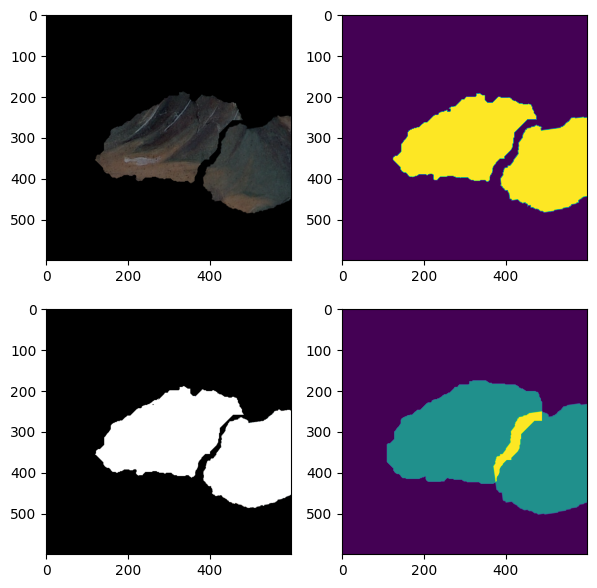

In [12]:
# score = compute_geom_morph_score(fr, tr)
# print(score)
blended = blend_fragments(fr, tr)
visualize_fragment(blended)

In [13]:
start_time = time.time()
res = match_fragments(
    pad_fragment(frag2, 200),
    pad_fragment(frag3, 200),
    (theta, int(shift_x), int(shift_y)),
    subcurve1,
    subcurve2
)
print("--- %s seconds ---" % (time.time() - start_time))

-52.02012755514744 286 59


100%|███████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.47it/s]

--- 33.800395488739014 seconds ---


# Visualizing

In [14]:
padded_frag2 = pad_fragment(frag2, 200)

0.7578905216890206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


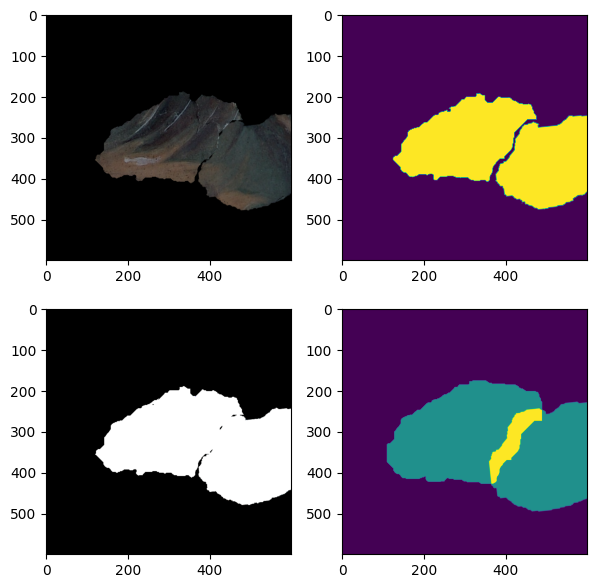

In [15]:
tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]
# corr = compute_geom_morph_score(padded_frag0, shift_fragment(padded_frag1, y, x))
print(tr.confidence)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(frag3, tr.angle), x, y)
blended = blend_fragments(padded_frag2, transformed)
visualize_fragment(blended)

In [66]:
start_time = time.time()
n = 20
for i in range(20):
    score = compute_geom_morph_score(padded_frag2, transformed)
print("--- %s seconds ---" % ((time.time() - start_time) / n))
            

--- 0.01490175724029541 seconds ---


In [67]:
start_time = time.time()
n = 20
for i in range(20):
    score = check_possibility_of_translation(padded_frag2, transformed)
print("--- %s seconds ---" % ((time.time() - start_time) / n))

--- 0.001752328872680664 seconds ---


In [69]:
start_time = time.time()
n = 20
for i in range(20):
    shift_fragment(padded_frag2, 100, 100)
print("--- %s seconds ---" % ((time.time() - start_time) / n))


--- 0.005306947231292725 seconds ---


In [70]:
from shape_utils import linearize_edge

In [ ]:
padded_frag2 = pad_fragment(frag2, 200)


In [77]:
edge1 = linearize_edge(frag1.mask)
edge2 = linearize_edge(frag2.mask)
edge3 = linearize_edge(frag3.mask)

In [78]:
edge3.shape

(1902, 2)

In [179]:
transformed_curve = np.zeros(edge3.shape)
sub2 = np.zeros(edge3.shape)
start_time = time.time()
transformed_curve[:, 0] = edge3[:,0] * np.cos(theta) + edge3[:, 1] * np.sin(theta) + shift_x - 5
transformed_curve[:, 1] = -edge3[:,0] * np.sin(theta) + edge3[:, 1] * np.cos(theta) + shift_y - 5
transformed_curve = transformed_curve.astype(int)
sub1 = [
    point 
    for point in transformed_curve 
    if point[1] < frag2.extended_mask.shape[0] and point[0] < frag2.extended_mask.shape[1] and frag2.extended_mask[int(point[1]), int(point[0])]
]
# sub2 = [point for point in edge3]
print("--- %s seconds ---" % ((time.time() - start_time)))

--- 0.004778623580932617 seconds ---


In [156]:
theta

-52.020127555148015

In [180]:
start_time = time.time()
transformed_subcurve = np.zeros(subcurve1.shape)
theta_rad = np.deg2rad(theta)
transformed_subcurve[:, 0] = subcurve1[:, 0] * np.cos(theta_rad) - subcurve1[:, 1] * np.sin(theta_rad) + shift_y - 5
transformed_subcurve[:, 1] = subcurve1[:, 0] * np.sin(theta_rad) + subcurve1[:, 1] * np.cos(theta_rad) + shift_x - 5
# transformed_subcurve[:, 0] = subcurve1[:, 0] * np.cos(theta) - subcurve1[:, 1] * np.sin(theta) 
# transformed_subcurve[:, 1] = subcurve1[:, 0] * np.sin(theta) + subcurve1[:, 1] * np.cos(theta) 
print(np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1)))
print("--- %s seconds ---" % ((time.time() - start_time)))

19.091463157321996
--- 0.00101470947265625 seconds ---


In [181]:
line1, line2, transformed_line1 = subcurve1.copy(), subcurve2.copy(), transformed_subcurve.copy()

In [182]:
subcurve1

array([[ 179,  -90],
       [ 178,  -90],
       [ 177,  -90],
       [ 176,  -90],
       [ 175,  -91],
       [ 174,  -91],
       [ 173,  -91],
       [ 172,  -92],
       [ 171,  -93],
       [ 170,  -94],
       [ 169,  -95],
       [ 168,  -96],
       [ 167,  -97],
       [ 166,  -97],
       [ 165,  -98],
       [ 164,  -99],
       [ 163, -100],
       [ 162, -100],
       [ 161, -101],
       [ 160, -101],
       [ 159, -102],
       [ 158, -102],
       [ 157, -102],
       [ 156, -102],
       [ 155, -102],
       [ 155, -102],
       [ 155, -102],
       [ 154, -101],
       [ 153, -101],
       [ 152, -100],
       [ 151, -100],
       [ 150, -101],
       [ 149, -101],
       [ 148, -102],
       [ 147, -102],
       [ 146, -101],
       [ 146, -101],
       [ 146, -101],
       [ 146, -101],
       [ 146, -101],
       [ 145, -101],
       [ 145, -101],
       [ 144, -100],
       [ 143, -100],
       [ 142, -100],
       [ 141, -100],
       [ 140, -100],
       [ 139,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


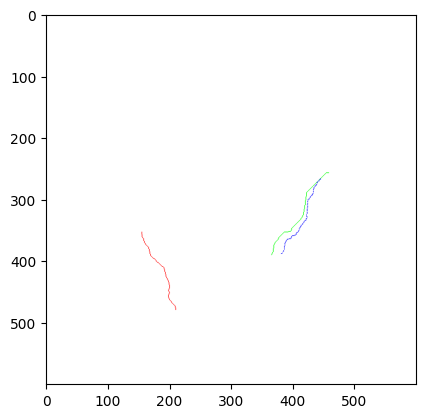

In [183]:
common_edge = np.ones(frag3.fragment.shape)
# color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
# indices = alignment[(l, r)]
# i_indices = [i for (i, j) in indices]
# for i, point in enumerate(edge_coords):
#     common_edge[point[0], point[1]] = 0.8
# common_edge = rgb2lab(common_edge)
    
# line1 = []
# colors = []
# for (i, j) in indices:
#     color = color_edge[i - 1]
#     y, x = edge_coords[i - 1]
#     line1.append((y, x))
#     colors.append(color)
    
    
# for c, (y, x) in zip(colors, line1):
#     common_edge[y, x] = c
# #     common_edge[y, x] = color

    
# plt.imshow(lab2rgb(common_edge))
# common_edge = lab2rgb(common_edge)
line1 += frag3.fragment.shape[0] // 2
line2 += frag3.fragment.shape[0] // 2
transformed_line1 += frag3.fragment.shape[0] // 2
for (y, x) in line1.astype(int):
    if y < 0 or y >= common_edge.shape[0] or x < 0 or x >= common_edge.shape[1]:
        continue
    common_edge[y, x] = [200, 0, 0]
for (y, x) in line2.astype(int):
    if y < 0 or y >= common_edge.shape[0] or x < 0 or x >= common_edge.shape[1]:
        continue
    common_edge[y, x] = [0, 200, 0]
for (y, x) in transformed_line1.astype(int):
    if y < 0 or y >= common_edge.shape[0] or x < 0 or x >= common_edge.shape[1]:
        continue
    common_edge[y, x] = [0, 0, 200]
# y1, x1 = edge_coords[indices[0][0] - 1]
# y2, x2 = edge_coords[indices[-1][0] - 1]
# plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

In [189]:
def compute_new_geom_morph_score(subcurve1, subcurve2, transform_params, max_distance=30):
    """
    subcurve1: (n, 2) array, common subcurve from frag1
    subcurve2: (n, 2) array, common subcurve from frag2
    transform_params: tuple of (theta, shift_x, shift_y)
    """
    theta, shift_x, shift_y = transform_params
    transformed_subcurve = np.zeros(subcurve1.shape)
    theta_rad = np.deg2rad(theta)
    transformed_subcurve[:, 0] = subcurve1[:, 0] * np.cos(theta_rad) - subcurve1[:, 1] * np.sin(theta_rad) + shift_y
    transformed_subcurve[:, 1] = subcurve1[:, 0] * np.sin(theta_rad) + subcurve1[:, 1] * np.cos(theta_rad) + shift_x
    score = (max_distance - np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1))) / max_distance
    
    return score ** (1 / 3) if score > 0 else 0

In [187]:
start_time = time.time()
n = 20
for i in range(20):
    score = compute_new_geom_morph_score(subcurve1, subcurve2, (theta, shift_x - 5, shift_y - 6))
print(score)
print("--- %s seconds ---" % ((time.time() - start_time) / n))

0.7099665530999734
--- 0.0003867626190185547 seconds ---
